__классификатор изображений на основе ResNet__

Евгений Борисов <esborisov@sevsu.ru>

---

Deep Residual Learning for Image Recognition  
Kaiming He, Xiangyu Zhang, Shaoqing Ren, Jian Sun   
Microsoft Research   
10 Dec 2015  

https://arxiv.org/pdf/1512.03385.pdf

---

In [1]:
import numpy as np
import matplotlib.pyplot as plt

from torch import no_grad

## загружаем данные

In [2]:
# каталог с картинками для классификации
data_path = '../data/imagenet/'

In [4]:
from torch.utils.data import DataLoader
from torchvision.datasets import ImageFolder
import torchvision.transforms as transforms

In [13]:
!pwd

/home/mechanoid/sevgu/2022-I-ml_lectorium/examples/24-convnet


In [14]:
# строим датасет
test_loader = DataLoader(
    ImageFolder(
        data_path, # каталог с файлами картинок
        transforms.Compose([ # нормализуем картинку в тензор
            transforms.ToTensor(),
            transforms.Resize(size=(224,224)),
            transforms.Normalize(mean=[0.485, 0.456, 0.406],std=[0.229, 0.224, 0.225]),
        ])
    ),
    batch_size=1024, # максимальное количество примеров в батче
)

next(iter(test_loader))[0].shape

torch.Size([10, 3, 224, 224])

## загружаем модель

In [15]:
from torchvision.models import resnet18

# загружаем предобученную модель 
model = resnet18(pretrained=True)

Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /home/mechanoid/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth


  0%|          | 0.00/44.7M [00:00<?, ?B/s]

In [16]:
from torchsummary import summary

summary(model, (3, 224, 224),device='cpu')

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 64, 112, 112]           9,408
       BatchNorm2d-2         [-1, 64, 112, 112]             128
              ReLU-3         [-1, 64, 112, 112]               0
         MaxPool2d-4           [-1, 64, 56, 56]               0
            Conv2d-5           [-1, 64, 56, 56]          36,864
       BatchNorm2d-6           [-1, 64, 56, 56]             128
              ReLU-7           [-1, 64, 56, 56]               0
            Conv2d-8           [-1, 64, 56, 56]          36,864
       BatchNorm2d-9           [-1, 64, 56, 56]             128
             ReLU-10           [-1, 64, 56, 56]               0
       BasicBlock-11           [-1, 64, 56, 56]               0
           Conv2d-12           [-1, 64, 56, 56]          36,864
      BatchNorm2d-13           [-1, 64, 56, 56]             128
             ReLU-14           [-1, 64,

## тестируем

In [17]:
from torch import no_grad

# выполняем классификацию бачта
X = next(iter(test_loader))[0] 

with no_grad(): # отключаем расчёт градиентов
    o = model(X).numpy()
    
p = np.argmax(o,axis=1).tolist()

In [18]:
# преобразуем тензор датасета обратно в картинки
def tensor2img(t):
    im = np.transpose( t.numpy(), (0, 2, 3, 1))
    im_mx,im_mn = im.max(axis=(1,2,3),keepdims=1),im.min(axis=(1,2,3),keepdims=1)
    return (((im-im_mn)/(im_mx-im_mn))*255.).astype(np.uint8)

im = tensor2img(X)

im.shape

(10, 224, 224, 3)

In [19]:
# загружаем описания меток классов датасета imagenet1000,
# на котором обучали модель

# https://gist.github.com/yrevar/942d3a0ac09ec9e5eb3a#file-imagenet1000_clsidx_to_labels-txt
with open('../data/imagenet/imagenet1000_clsidx_to_labels.txt', 'rt') as f: 
    imagenet_labels = eval(f.read())

In [20]:
def draw_images(
        x, # numpy тензор с картинками
        y=[], # метки классов
        class_names=None, # имена классов
        columns=3, # количество колонок в таблице с картинками  
        fig_width=14, # ширина таблицы с картинками
        num_ex=0, # рисуем только первые num_ex
        max_title_len=25 # максимальная длинна заголовка картинки
    ):
    # рисуем данные
    n_img = min(x.shape[0],num_ex) if num_ex>0 else x.shape[0]  # количество картинок для отображения
    col = columns # количество колонок
    w = fig_width # ширина таблицы с картинками
    h = (n_img//col)*(w//col) # высота таблицы с картинками

    fig = plt.figure(figsize=(w,h))
    for n in range(n_img):
        img = x[n,:] # извлекаем одну картинку
        plt.subplot(n_img//col+1,col,n+1) # создаём ячейку таблицы
        plt.axis(False) # оси координат не рисуем
        if len(y)==x.shape[0]:
            t = class_names[y[n]] # имя класса картинки
            t = t if len(t)<(max_title_len+1) else t[:max_title_len]+'...'
            plt.title(t) # заголовок картинки
        plt.imshow(img) # рисуем картинку
    fig.tight_layout() # выравниваем элементы таблицы


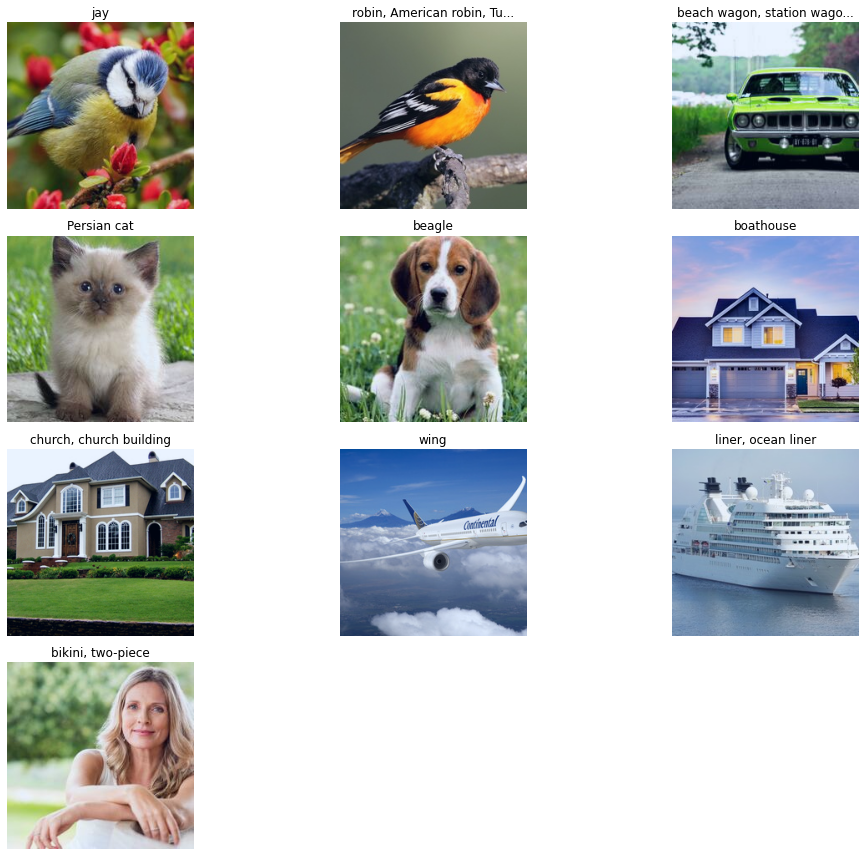

In [21]:
# рисуем результаты работы классификатора
draw_images(im,p,imagenet_labels)